# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

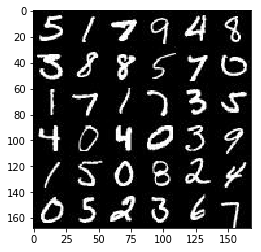

In [2]:
show_n_images = 36

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

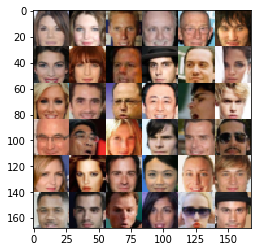

In [3]:
show_n_images = 36

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_tensor = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), "input_tensor")
    z_data = tf.placeholder(tf.float32, (None, z_dim), "z_data")
    learning_rate=tf.placeholder(tf.float32)
    
    
    return input_tensor, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.25
    drop_prob=0.1
    toTrain=True
    with tf.variable_scope('discriminator',reuse=reuse):
        
        cl_1= tf.layers.conv2d(images, 64,3,2, padding='same')
        relu_1=tf.maximum(cl_1, alpha*cl_1)
        
        dropout_1=tf.layers.dropout(relu_1, drop_prob)

        cl_2= tf.layers.conv2d(dropout_1, 128,3,2, padding='same')
        bn_1=tf.layers.batch_normalization(cl_2, training=toTrain)
        relu_2=tf.maximum(bn_1, alpha*bn_1)
        
        dropout_2=tf.layers.dropout(relu_2, drop_prob)
        
        cl_3= tf.layers.conv2d(dropout_2, 256,3,2, padding='same')
        bn_2=tf.layers.batch_normalization(cl_3, training=toTrain)
        relu_3=tf.maximum(bn_2, alpha*bn_2)
        
        shape = tf.reshape(relu_3, (-1, 4*4*256))
        output = tf.layers.dense(shape, 1, activation=None)
        
        return tf.sigmoid(output), output
        
        

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope("generator", reuse=not is_train):
        alpha=0.25
        drop_prob=0.1
        
        s1_l1=tf.layers.dense(z, 7*7*512)
        s1_l2=tf.reshape(s1_l1, (-1, 7,7,512))
        s1_l3=tf.layers.batch_normalization(s1_l2, training=is_train)
        s1_l4=tf.maximum(alpha*s1_l3, s1_l3)
        
        s2_l1=tf.layers.conv2d_transpose(s1_l4, 256, 3, 2, 'same', activation=None)
        s2_l2=tf.layers.batch_normalization(s2_l1, training=is_train)
        s2_l3=tf.maximum(alpha*s2_l2, s2_l2)
        s2_l4=tf.layers.dropout(s2_l3, drop_prob)
        
        s3_l1=tf.layers.conv2d_transpose(s2_l4, 128, 5, 1, 'same', activation=None)
        s3_l2=tf.layers.batch_normalization(s3_l1, training=is_train)
        s3_l3=tf.maximum(alpha*s3_l2, s3_l2)
        
        l_out=tf.layers.conv2d_transpose(s3_l3, out_channel_dim, 5, 2, 'same', activation=None)
        return tf.tanh(l_out)
        

    """
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    model_gen = generator(input_z, out_channel_dim)
    model_real, model_logits=discriminator(input_real, reuse=False)
    model_fake, model_logits_fake = discriminator(model_gen, reuse=True)
    
    real_model_loss=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=model_logits, labels=tf.ones_like(model_real)*0.9))
    fake_model_loss=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=model_logits_fake, labels=tf.zeros_like(model_fake)*0.9))
    model_gen_loss= tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=model_logits_fake, labels=tf.ones_like(model_fake)))

    return real_model_loss+fake_model_loss, model_gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    trainables = tf.trainable_variables()
    train_disc = [v for v in trainables if v.name.startswith('discriminator')]
    train_gen = [v for v in trainables if v.name.startswith('generator')]
    update = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update):
        opt_disc = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=train_disc)
    with tf.control_dependencies(update):    
        opt_gen = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=train_gen)
        
    
    return opt_disc, opt_gen


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, z_dat, l_r = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, z_dat, data_shape[3])
    d_opti, g_opti = model_opt( d_loss, g_loss, l_r, beta1)
    
    counter=0
    print_gap=20
    display_gap=60
    
   
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                counter = counter+1
                batch_images = batch_images*2
                batchpick=np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                a = sess.run(d_opti, feed_dict={l_r:learning_rate, input_real: batch_images, z_dat: batchpick})
                b = sess.run(g_opti, feed_dict={l_r:learning_rate, input_real: batch_images, z_dat: batchpick})
                
                if counter % print_gap == 0:
                    print("             Epoch: {:.0f} of {:.0f}".format(epoch_i+1,epoch_count))
                    print("Discriminator loss: {:.3f}".format(d_loss.eval({z_dat: batchpick, input_real: batch_images})))
                    print("    Generator loss: {:.3f}".format(g_loss.eval({z_dat: batchpick})))
                    
                if counter % display_gap ==0:
                    show_generator_output(sess, 25, z_dat, data_shape[3], data_image_mode)
                   
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

             Epoch: 1 of 2
Discriminator loss: 0.994
    Generator loss: 2.887
             Epoch: 1 of 2
Discriminator loss: 1.669
    Generator loss: 0.509
             Epoch: 1 of 2
Discriminator loss: 2.085
    Generator loss: 0.283


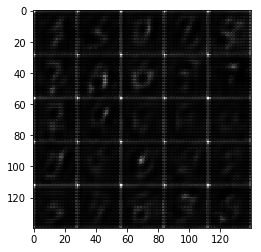

             Epoch: 1 of 2
Discriminator loss: 1.587
    Generator loss: 0.605
             Epoch: 1 of 2
Discriminator loss: 1.283
    Generator loss: 1.016
             Epoch: 1 of 2
Discriminator loss: 1.319
    Generator loss: 0.882


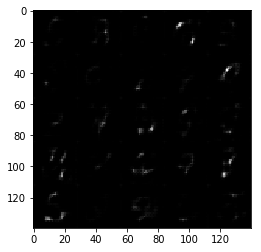

             Epoch: 1 of 2
Discriminator loss: 1.462
    Generator loss: 0.900
             Epoch: 1 of 2
Discriminator loss: 1.273
    Generator loss: 1.213
             Epoch: 1 of 2
Discriminator loss: 1.239
    Generator loss: 1.358


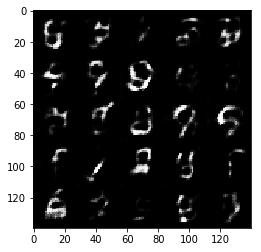

             Epoch: 1 of 2
Discriminator loss: 1.224
    Generator loss: 1.114
             Epoch: 1 of 2
Discriminator loss: 1.338
    Generator loss: 1.032
             Epoch: 1 of 2
Discriminator loss: 1.348
    Generator loss: 1.215


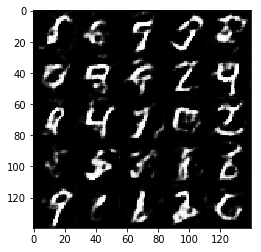

             Epoch: 1 of 2
Discriminator loss: 1.364
    Generator loss: 0.872
             Epoch: 1 of 2
Discriminator loss: 1.168
    Generator loss: 1.054
             Epoch: 1 of 2
Discriminator loss: 1.169
    Generator loss: 1.224


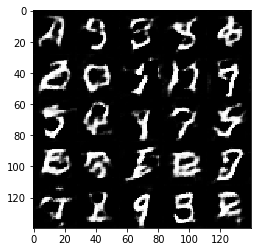

             Epoch: 1 of 2
Discriminator loss: 1.291
    Generator loss: 1.250
             Epoch: 1 of 2
Discriminator loss: 1.306
    Generator loss: 0.675
             Epoch: 1 of 2
Discriminator loss: 1.189
    Generator loss: 0.820


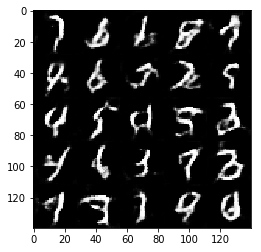

             Epoch: 1 of 2
Discriminator loss: 2.031
    Generator loss: 2.720
             Epoch: 1 of 2
Discriminator loss: 1.303
    Generator loss: 1.286
             Epoch: 1 of 2
Discriminator loss: 1.201
    Generator loss: 1.154


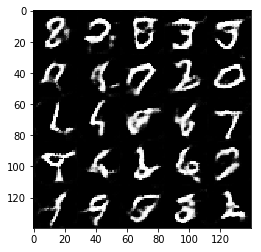

             Epoch: 1 of 2
Discriminator loss: 1.210
    Generator loss: 0.983
             Epoch: 1 of 2
Discriminator loss: 1.180
    Generator loss: 1.582
             Epoch: 2 of 2
Discriminator loss: 1.250
    Generator loss: 1.000


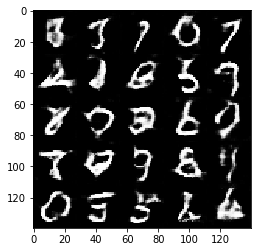

             Epoch: 2 of 2
Discriminator loss: 1.154
    Generator loss: 0.948
             Epoch: 2 of 2
Discriminator loss: 1.158
    Generator loss: 1.042
             Epoch: 2 of 2
Discriminator loss: 1.214
    Generator loss: 0.806


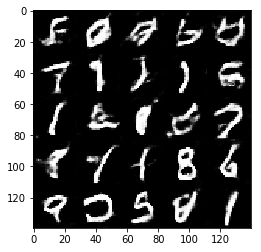

             Epoch: 2 of 2
Discriminator loss: 1.383
    Generator loss: 1.117
             Epoch: 2 of 2
Discriminator loss: 1.187
    Generator loss: 1.112
             Epoch: 2 of 2
Discriminator loss: 2.664
    Generator loss: 3.267


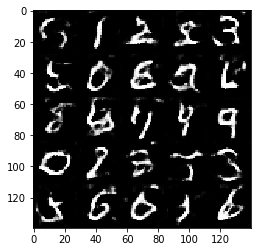

             Epoch: 2 of 2
Discriminator loss: 1.078
    Generator loss: 1.211
             Epoch: 2 of 2
Discriminator loss: 1.330
    Generator loss: 0.754
             Epoch: 2 of 2
Discriminator loss: 1.277
    Generator loss: 1.052


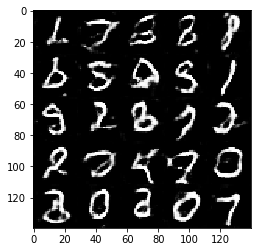

             Epoch: 2 of 2
Discriminator loss: 1.058
    Generator loss: 1.123
             Epoch: 2 of 2
Discriminator loss: 1.190
    Generator loss: 0.967
             Epoch: 2 of 2
Discriminator loss: 1.106
    Generator loss: 1.275


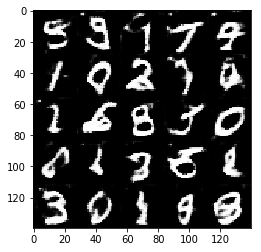

             Epoch: 2 of 2
Discriminator loss: 1.181
    Generator loss: 0.865
             Epoch: 2 of 2
Discriminator loss: 1.143
    Generator loss: 0.760
             Epoch: 2 of 2
Discriminator loss: 0.947
    Generator loss: 1.286


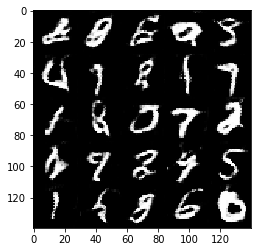

             Epoch: 2 of 2
Discriminator loss: 1.162
    Generator loss: 0.950
             Epoch: 2 of 2
Discriminator loss: 1.712
    Generator loss: 2.364
             Epoch: 2 of 2
Discriminator loss: 1.527
    Generator loss: 0.412


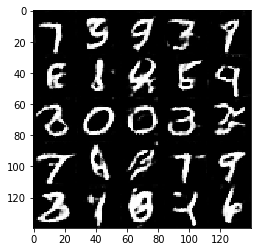

             Epoch: 2 of 2
Discriminator loss: 2.869
    Generator loss: 3.906
             Epoch: 2 of 2
Discriminator loss: 1.020
    Generator loss: 1.072
             Epoch: 2 of 2
Discriminator loss: 1.174
    Generator loss: 0.817


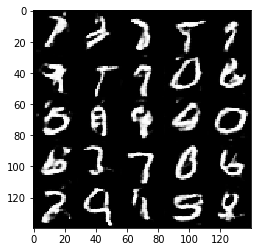

             Epoch: 2 of 2
Discriminator loss: 0.830
    Generator loss: 1.851


In [12]:
batch_size = 128
z_dim = 64
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

# CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

             Epoch: 1 of 1
Discriminator loss: 2.470
    Generator loss: 0.294
             Epoch: 1 of 1
Discriminator loss: 1.533
    Generator loss: 1.173
             Epoch: 1 of 1
Discriminator loss: 1.616
    Generator loss: 0.500


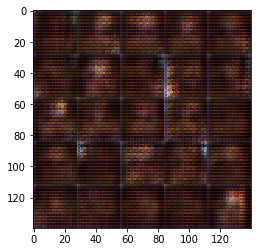

             Epoch: 1 of 1
Discriminator loss: 4.916
    Generator loss: 0.019
             Epoch: 1 of 1
Discriminator loss: 1.542
    Generator loss: 0.714
             Epoch: 1 of 1
Discriminator loss: 1.410
    Generator loss: 0.558


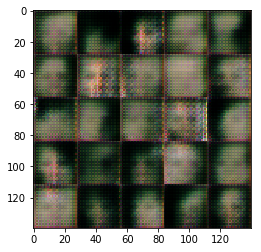

             Epoch: 1 of 1
Discriminator loss: 1.585
    Generator loss: 0.530
             Epoch: 1 of 1
Discriminator loss: 1.127
    Generator loss: 1.158
             Epoch: 1 of 1
Discriminator loss: 1.514
    Generator loss: 0.871


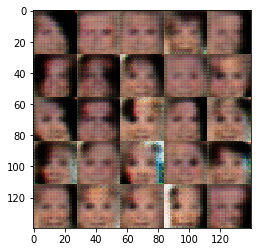

             Epoch: 1 of 1
Discriminator loss: 1.188
    Generator loss: 0.704
             Epoch: 1 of 1
Discriminator loss: 1.260
    Generator loss: 1.048
             Epoch: 1 of 1
Discriminator loss: 1.450
    Generator loss: 0.636


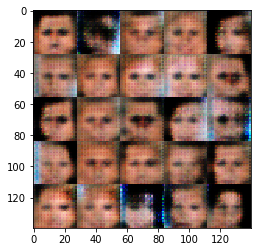

             Epoch: 1 of 1
Discriminator loss: 1.602
    Generator loss: 0.992
             Epoch: 1 of 1
Discriminator loss: 2.178
    Generator loss: 2.450
             Epoch: 1 of 1
Discriminator loss: 1.327
    Generator loss: 1.336


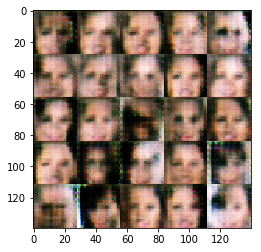

             Epoch: 1 of 1
Discriminator loss: 1.418
    Generator loss: 0.860
             Epoch: 1 of 1
Discriminator loss: 1.261
    Generator loss: 0.802
             Epoch: 1 of 1
Discriminator loss: 1.002
    Generator loss: 1.212


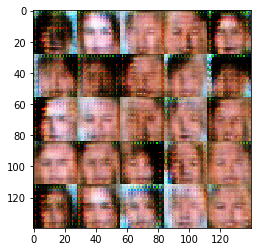

             Epoch: 1 of 1
Discriminator loss: 1.574
    Generator loss: 0.795
             Epoch: 1 of 1
Discriminator loss: 1.575
    Generator loss: 0.586
             Epoch: 1 of 1
Discriminator loss: 1.371
    Generator loss: 0.816


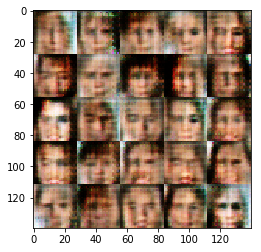

             Epoch: 1 of 1
Discriminator loss: 1.079
    Generator loss: 1.117
             Epoch: 1 of 1
Discriminator loss: 1.414
    Generator loss: 0.794
             Epoch: 1 of 1
Discriminator loss: 1.288
    Generator loss: 0.675


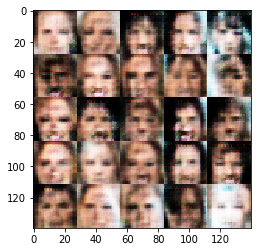

             Epoch: 1 of 1
Discriminator loss: 1.212
    Generator loss: 1.262
             Epoch: 1 of 1
Discriminator loss: 1.451
    Generator loss: 0.720
             Epoch: 1 of 1
Discriminator loss: 1.315
    Generator loss: 0.718


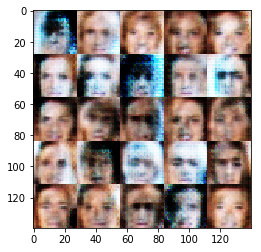

             Epoch: 1 of 1
Discriminator loss: 1.973
    Generator loss: 0.248
             Epoch: 1 of 1
Discriminator loss: 1.439
    Generator loss: 0.941
             Epoch: 1 of 1
Discriminator loss: 1.463
    Generator loss: 0.904


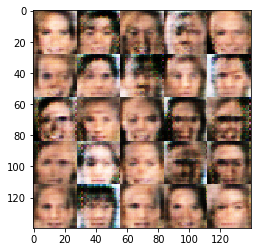

             Epoch: 1 of 1
Discriminator loss: 1.179
    Generator loss: 0.806
             Epoch: 1 of 1
Discriminator loss: 1.514
    Generator loss: 0.651
             Epoch: 1 of 1
Discriminator loss: 1.432
    Generator loss: 0.518


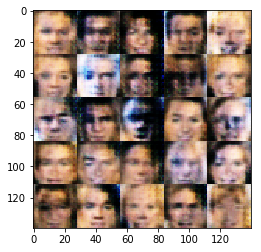

             Epoch: 1 of 1
Discriminator loss: 1.242
    Generator loss: 0.916
             Epoch: 1 of 1
Discriminator loss: 1.200
    Generator loss: 0.786
             Epoch: 1 of 1
Discriminator loss: 1.243
    Generator loss: 0.828


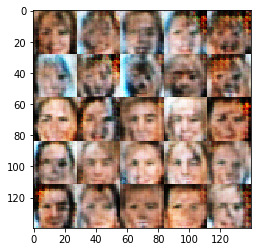

             Epoch: 1 of 1
Discriminator loss: 1.293
    Generator loss: 0.729
             Epoch: 1 of 1
Discriminator loss: 1.355
    Generator loss: 0.982
             Epoch: 1 of 1
Discriminator loss: 1.346
    Generator loss: 1.340


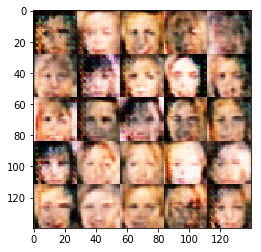

             Epoch: 1 of 1
Discriminator loss: 1.261
    Generator loss: 0.832
             Epoch: 1 of 1
Discriminator loss: 1.123
    Generator loss: 0.940
             Epoch: 1 of 1
Discriminator loss: 1.002
    Generator loss: 1.212


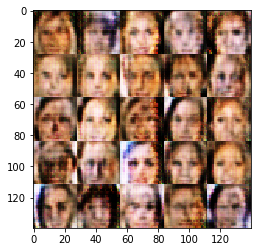

             Epoch: 1 of 1
Discriminator loss: 1.147
    Generator loss: 0.954
             Epoch: 1 of 1
Discriminator loss: 1.540
    Generator loss: 0.764
             Epoch: 1 of 1
Discriminator loss: 1.673
    Generator loss: 0.444


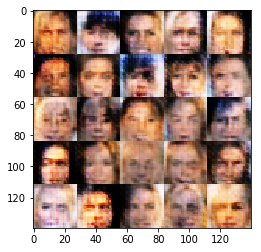

             Epoch: 1 of 1
Discriminator loss: 1.383
    Generator loss: 0.865
             Epoch: 1 of 1
Discriminator loss: 1.240
    Generator loss: 0.814
             Epoch: 1 of 1
Discriminator loss: 1.734
    Generator loss: 1.930


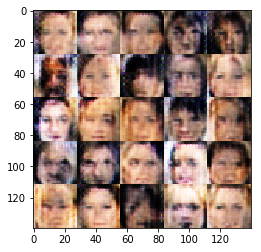

             Epoch: 1 of 1
Discriminator loss: 1.295
    Generator loss: 0.864
             Epoch: 1 of 1
Discriminator loss: 1.248
    Generator loss: 0.755
             Epoch: 1 of 1
Discriminator loss: 1.152
    Generator loss: 1.198


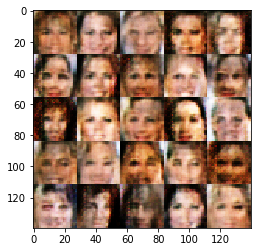

             Epoch: 1 of 1
Discriminator loss: 1.770
    Generator loss: 0.760
             Epoch: 1 of 1
Discriminator loss: 1.341
    Generator loss: 0.740
             Epoch: 1 of 1
Discriminator loss: 1.278
    Generator loss: 0.814


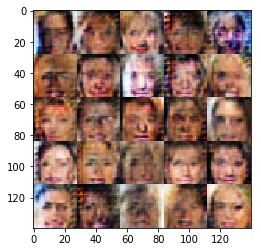

             Epoch: 1 of 1
Discriminator loss: 1.255
    Generator loss: 0.849
             Epoch: 1 of 1
Discriminator loss: 2.027
    Generator loss: 0.267
             Epoch: 1 of 1
Discriminator loss: 1.366
    Generator loss: 0.780


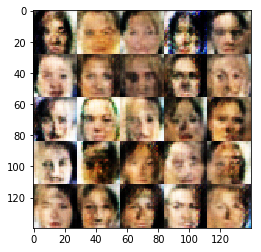

             Epoch: 1 of 1
Discriminator loss: 1.569
    Generator loss: 0.576
             Epoch: 1 of 1
Discriminator loss: 1.488
    Generator loss: 1.024
             Epoch: 1 of 1
Discriminator loss: 1.285
    Generator loss: 0.716


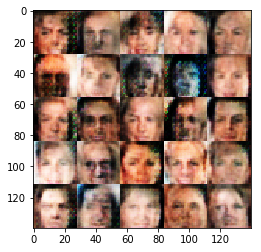

             Epoch: 1 of 1
Discriminator loss: 1.308
    Generator loss: 0.872
             Epoch: 1 of 1
Discriminator loss: 1.373
    Generator loss: 0.690
             Epoch: 1 of 1
Discriminator loss: 1.360
    Generator loss: 0.728


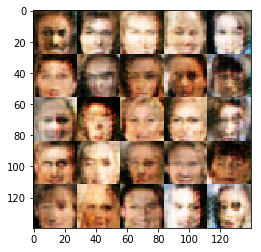

             Epoch: 1 of 1
Discriminator loss: 1.342
    Generator loss: 0.974
             Epoch: 1 of 1
Discriminator loss: 1.369
    Generator loss: 0.760
             Epoch: 1 of 1
Discriminator loss: 1.293
    Generator loss: 0.715


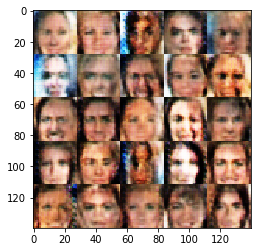

             Epoch: 1 of 1
Discriminator loss: 1.339
    Generator loss: 1.152
             Epoch: 1 of 1
Discriminator loss: 1.337
    Generator loss: 0.660
             Epoch: 1 of 1
Discriminator loss: 1.728
    Generator loss: 0.365


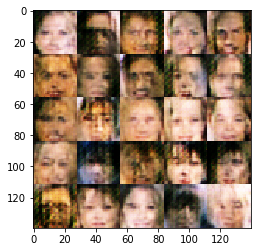

             Epoch: 1 of 1
Discriminator loss: 1.253
    Generator loss: 0.925
             Epoch: 1 of 1
Discriminator loss: 1.465
    Generator loss: 0.684
             Epoch: 1 of 1
Discriminator loss: 1.358
    Generator loss: 1.196


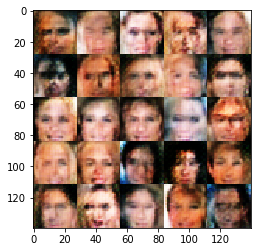

             Epoch: 1 of 1
Discriminator loss: 1.481
    Generator loss: 0.839
             Epoch: 1 of 1
Discriminator loss: 1.487
    Generator loss: 1.023
             Epoch: 1 of 1
Discriminator loss: 1.387
    Generator loss: 1.066


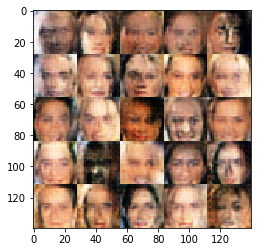

             Epoch: 1 of 1
Discriminator loss: 1.429
    Generator loss: 0.687
             Epoch: 1 of 1
Discriminator loss: 1.276
    Generator loss: 0.841
             Epoch: 1 of 1
Discriminator loss: 1.360
    Generator loss: 0.766


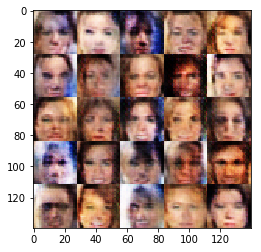

             Epoch: 1 of 1
Discriminator loss: 1.162
    Generator loss: 0.854


In [13]:
batch_size = 128
z_dim = 64
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.